In [70]:
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;
sns.set( style = 'ticks', color_codes = True )

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, SpectralClustering

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

import umap

In [2]:
pd.options.display.max_columns = 200

# Data Loading - Old Data

In [20]:
salurbal_old_df = pd.read_csv( '../data/datos.csv' )[ [ 'Country', 'L1Name', 'L2Namev2' ] ]

In [21]:
salurbal_old_df.shape

(1354, 3)

In [22]:
#salurbal_old_df.head()

# Data Loading

In [23]:
salurbal_df = pd.read_excel( '../data/modelos L2.xlsx' )

In [24]:
salurbal_df.shape

(1354, 51)

In [25]:
#salurbal_df.head()

# Merging for get L1Names

In [26]:
salurbal_df[ 'L1Name' ] = salurbal_old_df[ 'L1Name' ]

In [27]:
salurbal_df.shape

(1354, 52)

In [28]:
#salurbal_df.head()

# Cleaning Data

In [29]:
# Eliminación de columnas sin utilidad
del salurbal_df[ 'salid2' ]
del salurbal_df[ 'bicycle lane' ]

In [30]:
# Se elimina el modelo completo que ya no se utilizará
del salurbal_df[ 'clase-completo' ]
del salurbal_df[ 'prob1-completo' ]
del salurbal_df[ 'prob2-completo' ]
del salurbal_df[ 'prob3-completo' ]

In [31]:
salurbal_df.rename( columns = { 'L2Namev2': 'L2NAME', 'Country': 'COUNTRY', 'L1Name': 'L1NAME',
                               'clase-BE': 'MBE_CLUSTER', 'prob1-BE': 'MBE_PROB1', 'prob2-BE': 'MBE_PROB2', 'prob3-BE': 'MBE_PROB3', 'prob4-BE': 'MBE_PROB4', 'prob5-BE': 'MBE_PROB5', 
                               'clase_Transport': 'MT_CLUSTER', 'prob1-Transport': 'MT_PROB1', 'prob2-Transport': 'MT_PROB2', 'prob3-Transport': 'MT_PROB3', 'prob4-Transport': 'MT_PROB4', 'prob5-Transport': 'MT_PROB5' 
                              }, inplace = True )

In [32]:
salurbal_df.shape

(1354, 46)

In [33]:
#salurbal_df.dtypes

In [34]:
salurbal_df[ 'MT_CLUSTER' ].value_counts( dropna = False )

2    400
3    328
5    265
4    204
1    157
Name: MT_CLUSTER, dtype: int64

In [35]:
salurbal_df[ 'MT_PROB' ] = salurbal_df.apply( lambda x: x[ 'MT_PROB' + str( x[ 'MT_CLUSTER' ] ) ], axis = 1 )

In [36]:
salurbal_df.loc[ salurbal_df[ 'MT_PROB' ] >= .9, 'MT_CLUSTER' ].value_counts( dropna = False )

2    326
3    271
5    215
4    180
1    148
Name: MT_CLUSTER, dtype: int64

In [39]:
# L2s with membership probability major or equal than 0.9
salurbal_df.loc[ salurbal_df[ 'MT_PROB' ] >= .9, 'MT_CLUSTER' ].value_counts( dropna = False ).sum() / salurbal_df[ 'MT_CLUSTER' ].value_counts( dropna = False ).sum()

0.8419497784342689

In [42]:
salurbal_df[ 'MBE_CLUSTER' ].value_counts( dropna = False )

2    403
5    385
4    352
1    140
3     74
Name: MBE_CLUSTER, dtype: int64

In [40]:
salurbal_df[ 'MBE_PROB' ] = salurbal_df.apply( lambda x: x[ 'MBE_PROB' + str( x[ 'MBE_CLUSTER' ] ) ], axis = 1 )

In [41]:
salurbal_df.loc[ salurbal_df[ 'MBE_PROB' ] >= .9, 'MBE_CLUSTER' ].value_counts( dropna = False )

2    371
5    365
4    325
1    134
3     69
Name: MBE_CLUSTER, dtype: int64

In [43]:
# L2s with membership probability major or equal than 0.9
salurbal_df.loc[ salurbal_df[ 'MBE_PROB' ] >= .9, 'MBE_CLUSTER' ].value_counts( dropna = False ).sum() / salurbal_df[ 'MBE_CLUSTER' ].value_counts( dropna = False ).sum()

0.9335302806499262

In [44]:
# Crea una columna contando la cantidad de valores faltantes
salurbal_df[ 'missings' ] = salurbal_df.isnull().sum( axis = 1 )

In [48]:
# Removing of records with more than 2 missing values  => 3 records removed
salurbal_df = salurbal_df.loc[ salurbal_df[ 'missings' ] <= 2 ]

In [49]:
salurbal_df[ 'missings' ].value_counts( dropna = False )

1    1229
0     106
2      16
Name: missings, dtype: int64

In [55]:
# Muestra las columnas con valores faltantes
salurbal_df.isnull().sum( axis = 0 ).sort_values( ascending = False ).head( 2 )

BECBYLANELNGTHL2    1206
BECAWMNNNGHL2         55
dtype: int64

In [57]:
# Imputation with median
salurbal_df.loc[ salurbal_df[ 'BECAWMNNNGHL2' ].isnull(), 'BECAWMNNNGHL2' ] = salurbal_df[ 'BECAWMNNNGHL2' ].median()

In [58]:
del salurbal_df[ 'missings' ]

In [60]:
features = [ 'BECTUAREAL2', 'BECPCTURBANL2', 'BECNURBPTCHL2', 'BECPTCHDENSL2', 'BECAVGPTCHAREAL2', 'BECCVPTCHAREAL2', 'BECAWMNSHPINDXL2', 'BECAWMNNNGHL2', 'BECEDGDENSL2', 'BECEFFMESHSIZEL2', 'BECAWAVGPTCHAREAL2', 'BECAWEDGDENSL2', 'BECTPOPL2', 'BECPOPDENSL2', 'BECPOPCONCL2', 'BECTPOPADJL2', 'BECPOPDENSADJL2', 'BECPRSBRTL2', 'BECPRSSUBWAYL2', 'BECBYLANELNGTHL2', 'BECADAREAL2', 'BECADCRCTYAVGL2', 'BECADINTDENS3L2', 'BECADINTDENS4L2', 'BECADINTDENSL2', 'BECADLRDENSL2', 'BECADSTTDENSL2', 'BECADSTTPNODEAVGL2', 'BECADSTTPNODESDL2', 'BECADSTTLGAVGL2', 'BECURBTRVDELAYINDEXL2' ]

In [62]:
mbe_features = [ 'BECAWMNSHPINDXL2', 'BECEFFMESHSIZEL2', 'BECAWMNNNGHL2', 'BECAWEDGDENSL2', 'BECPTCHDENSL2', 'BECNURBPTCHL2', 'BECAWAVGPTCHAREAL2' ]

In [63]:
mt_features = [ 'BECPRSBRTL2', 'BECPRSSUBWAYL2', 'BECADSTTDENSL2', 'BECADSTTLGAVGL2', 'BECADINTDENSL2', 'BECADCRCTYAVGL2', 'BECADSTTPNODEAVGL2' ]

In [64]:
salurbal_df.head()

MT_CLUSTER      MT_PROB1  MT_PROB2       MT_PROB3      MT_PROB4  MT_PROB5  \
0           2  1.006644e-09  0.990227   6.789038e-03  4.024870e-06   0.00298   
1           1  1.000000e+00  0.000000  2.597576e-165  2.851603e-16   0.00000   
2           1  1.000000e+00  0.000000  3.043838e-122  1.853233e-11   0.00000   
3           1  1.000000e+00  0.000000   4.062238e-92  3.665810e-08   0.00000   
4           1  1.000000e+00  0.000000  1.553341e-102  4.159393e-09   0.00000   

   MBE_CLUSTER     MBE_PROB1      MBE_PROB2     MBE_PROB3     MBE_PROB4  \
0            2  2.034067e-05   9.999797e-01  0.000000e+00  3.163931e-09   
1            3  8.495793e-09  1.196134e-305  9.999761e-01  2.393793e-05   
2            4  3.406003e-08   0.000000e+00  4.847438e-11  1.000000e+00   
3            3  1.018032e-05   0.000000e+00  5.970702e-01  4.029196e-01   
4            3  1.071469e-10  4.960718e-193  9.999799e-01  2.005005e-05   

       MBE_PROB5            L2NAME    COUNTRY  BECTUAREAL2  BECPCTURBANL2  \
0  2.548909e-228      Bahía Blanca  Argentina    6708.9607         2.9362   
1   0.000000e+00  CABA - Comuna 12  Argentina    1557.1800       100.0000   
2   0.000000e+00  CABA - Comuna 13  Argentina    1367.6403        92.9533   
3   0.000000e+00   CABA - Comuna 4  Argentina    2108.7000        95.1743   
4   0.000000e+00   CABA - Comuna 6  Argentina     684.9000       100.0000   

   BECNURBPTCHL2  BECPTCHDENSL2  BECAVGPTCHAREAL2  BECCVPTCHAREAL2  \
0            487         0.2131           13.7761        1381.9916   
1              1         0.0642         1557.1800           0.0000   
2             13         0.8836          105.2031         345.3484   
3              8         0.3611          263.5875         263.3112   
4              1         0.1460          684.9000           0.0000   

   BECAWMNSHPINDXL2  BECAWMNNNGHL2  BECEDGDENSL2  BECEFFMESHSIZEL2  \
0            5.1337       76.64910        3.0487           77.6599   
1            1.4735       76.50085        0.0000         1557.1800   
2            2.5395       60.04620       11.5814         1264.0834   
3            2.2122       67.16730        6.6347         1990.2022   
4            1.2914       76.50085        0.0000          684.9000   

   BECAWAVGPTCHAREAL2  BECAWEDGDENSL2  BECTPOPL2  BECPOPDENSL2  BECPOPCONCL2  \
0           2644.8742        0.420828   301664.6      2266.861      0.968855   
1           1557.1800       14.988633   198821.2     12768.030      0.466060   
2           1359.9129       24.739527   228600.5     16144.350      0.542869   
3           2091.1138       18.119355   208014.2      9748.383      0.588839   
4            684.9000       19.798511   172907.1     25245.600      0.394381   

   BECTPOPADJL2  BECPOPDENSADJL2  BECPRSBRTL2  BECPRSSUBWAYL2  \
0      303883.9         2283.536            0               0   
1      200283.8        12861.960            1               1   
2      230282.1        16263.110            1               1   
3      209544.2         9820.085            1               1   
4      174179.0        25431.300            0               1   

   BECBYLANELNGTHL2  BECADAREAL2  BECADCRCTYAVGL2  BECADINTDENS3L2  \
0               NaN  2288.640950         1.032761         1.814614   
1          9.701940    15.609046         1.010627        31.007661   
2          7.750455    14.761826         1.026108        32.516303   
3         10.812998    22.192225         1.027101        38.662188   
4          6.646486     6.867352         1.005764        30.142623   

   BECADINTDENS4L2  BECADINTDENSL2  BECADLRDENSL2  BECADSTTDENSL2  \
0         1.812866        3.672485       1.477944      939.287799   
1        68.934388      102.376535    1114.706121    18590.830836   
2        56.022881       90.571453     877.670053    16060.259206   
3        39.338101       79.577418     852.810300    14502.014548   
4        52.276336       83.147041    1318.272414    15379.258560   

   BECADSTTPNODEAVGL2  BECADSTTPNODESDL2  BECADSTTLGAVGL2 

# Data Exploration

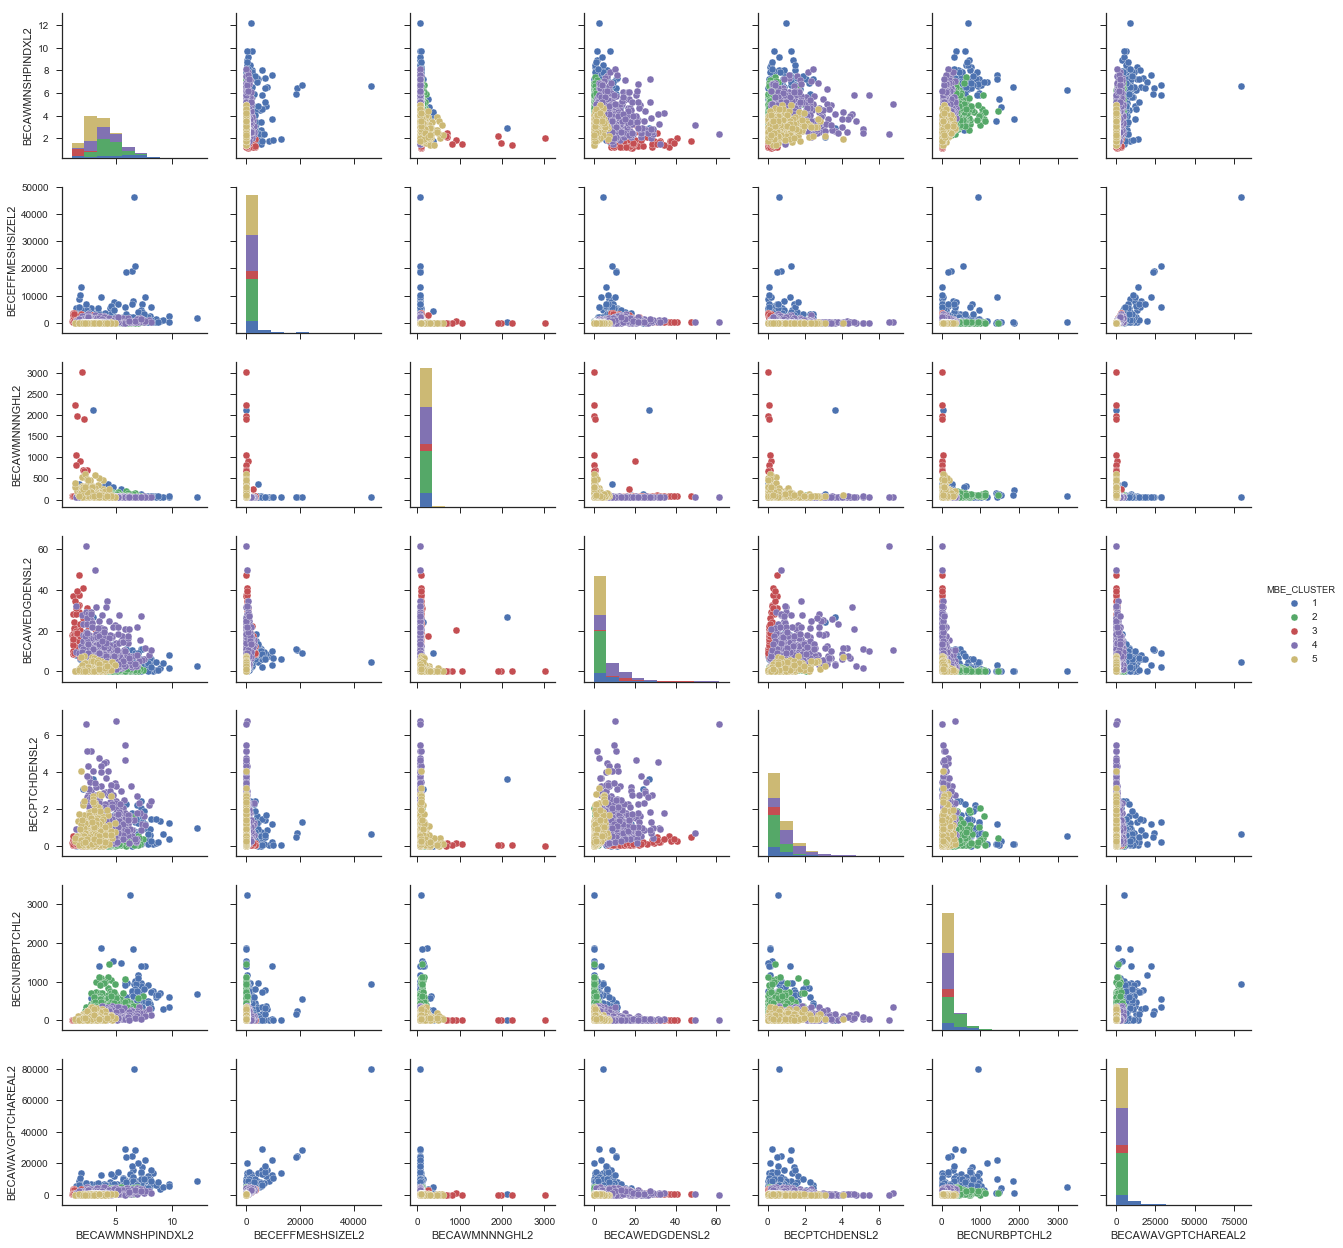

In [68]:
sns.pairplot( salurbal_df, vars = mbe_features, hue = 'MBE_CLUSTER' )

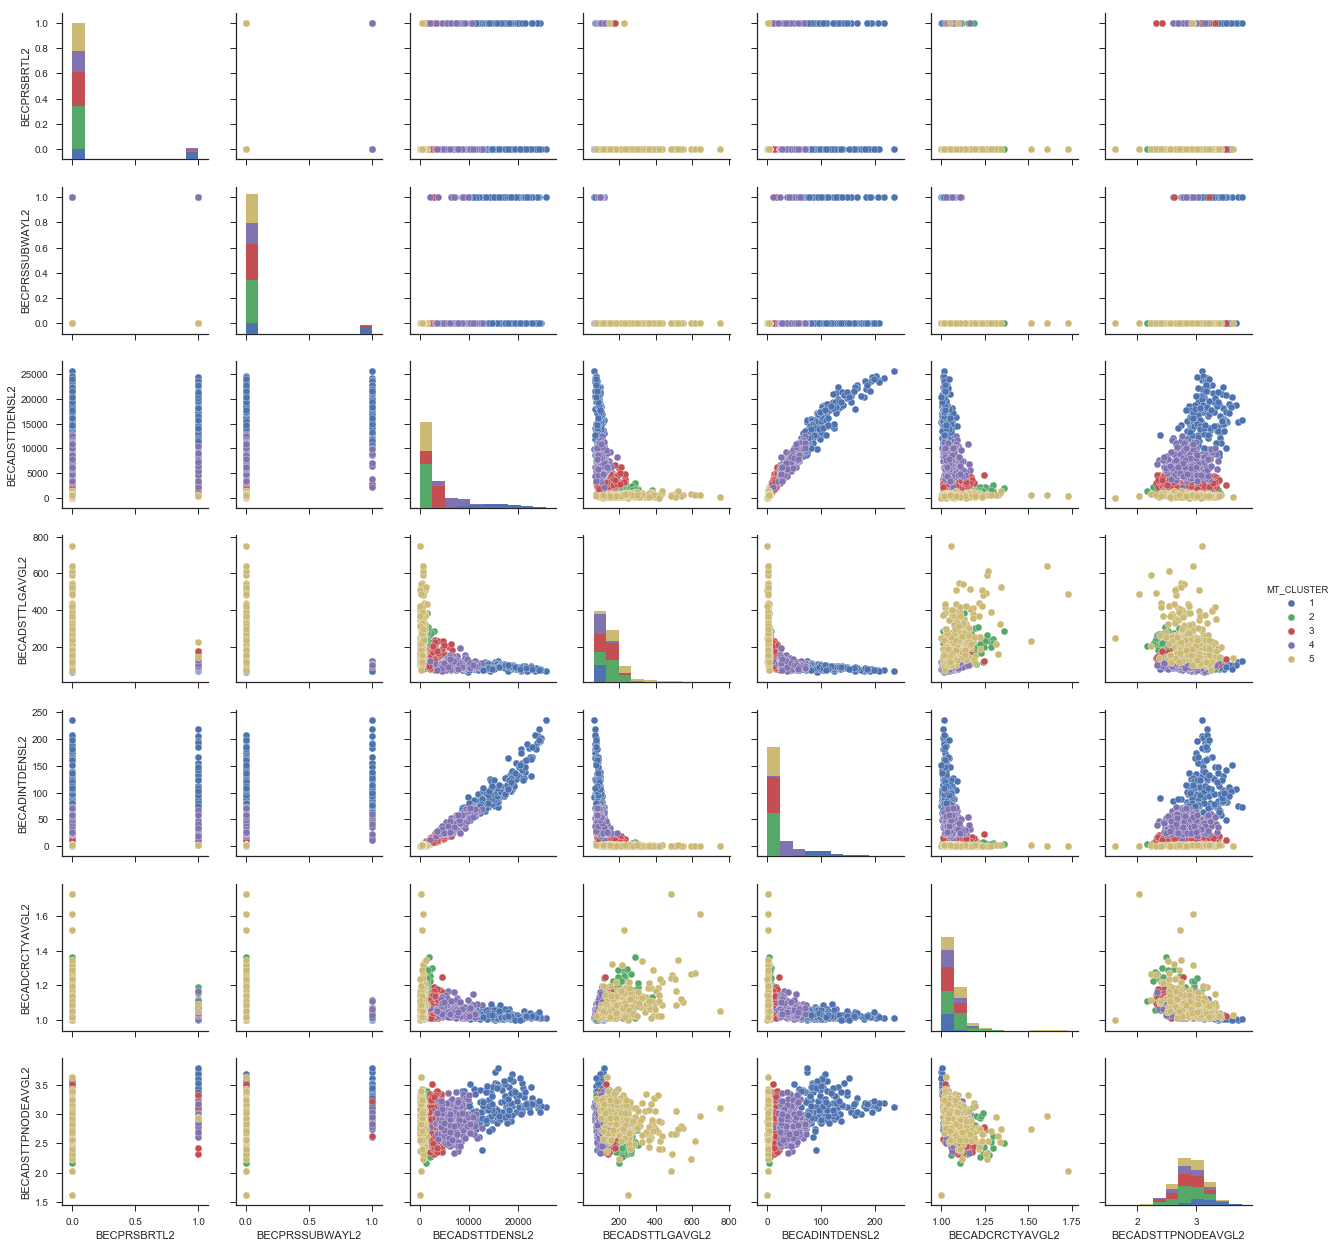

In [69]:
sns.pairplot( salurbal_df, vars = mt_features, hue = 'MT_CLUSTER' )

# Complementary Clustering

### K-Means

In [78]:
kmeans_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'clustering', KMeans( n_clusters = 5, n_jobs = -1, random_state = 1 ) )
] )

In [140]:
kmeans_mbe_salurbal = kmeans_pipeline.fit_predict( salurbal_df[ mbe_features ] )

for i in range( kmeans_mbe_salurbal.shape[ 0 ] ):
    kmeans_mbe_salurbal[ i ] = kmeans_mbe_salurbal[ i ] + 1

In [141]:
kmeans_mt_salurbal = kmeans_pipeline.fit_predict( salurbal_df[ mt_features ] )

for i in range( kmeans_mt_salurbal.shape[ 0 ] ):
    kmeans_mt_salurbal[ i ] = kmeans_mt_salurbal[ i ] + 1

In [142]:
salurbal_df[ 'MBE_CLUSTER_KMEANS' ] = kmeans_mbe_salurbal

salurbal_df[ 'MT_CLUSTER_KMEANS' ] = kmeans_mt_salurbal

In [143]:
salurbal_df[ 'MBE_CLUSTER_KMEANS' ].value_counts( dropna = False )

1    811
5    293
3    235
2      7
4      5
Name: MBE_CLUSTER_KMEANS, dtype: int64

In [144]:
salurbal_df[ 'MT_CLUSTER_KMEANS' ].value_counts( dropna = False )

5    583
3    477
2    112
1    105
4     74
Name: MT_CLUSTER_KMEANS, dtype: int64

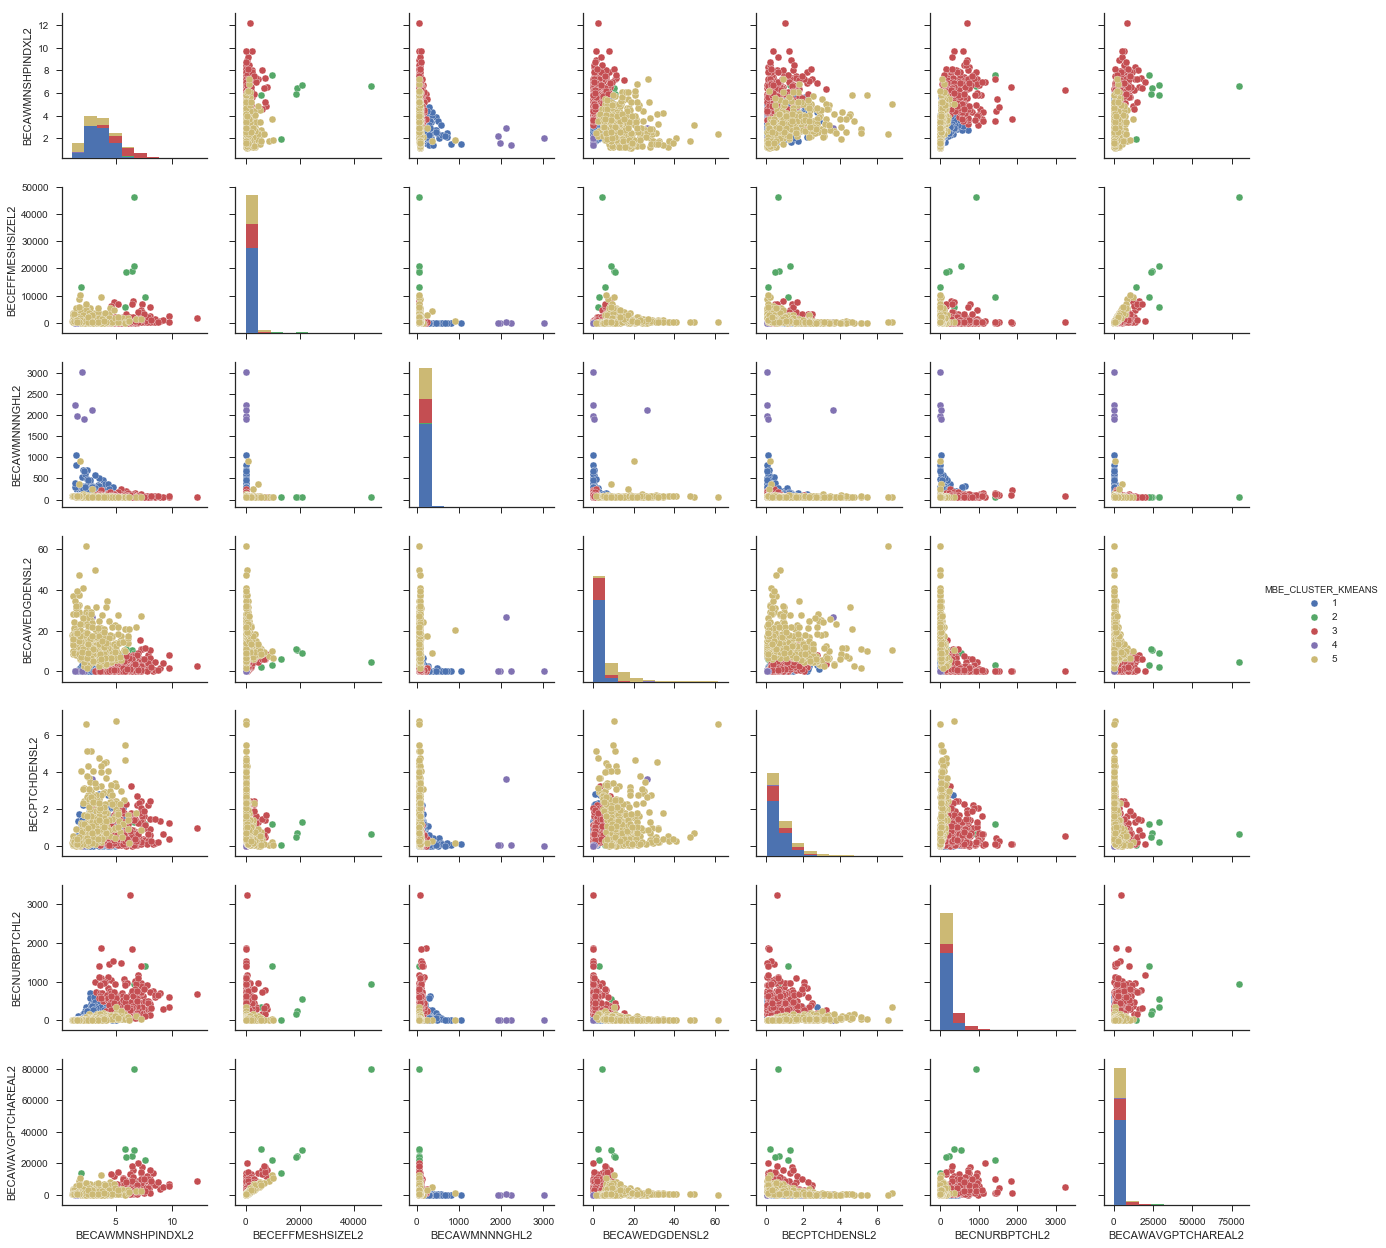

In [145]:
sns.pairplot( salurbal_df, vars = mbe_features, hue = 'MBE_CLUSTER_KMEANS' )

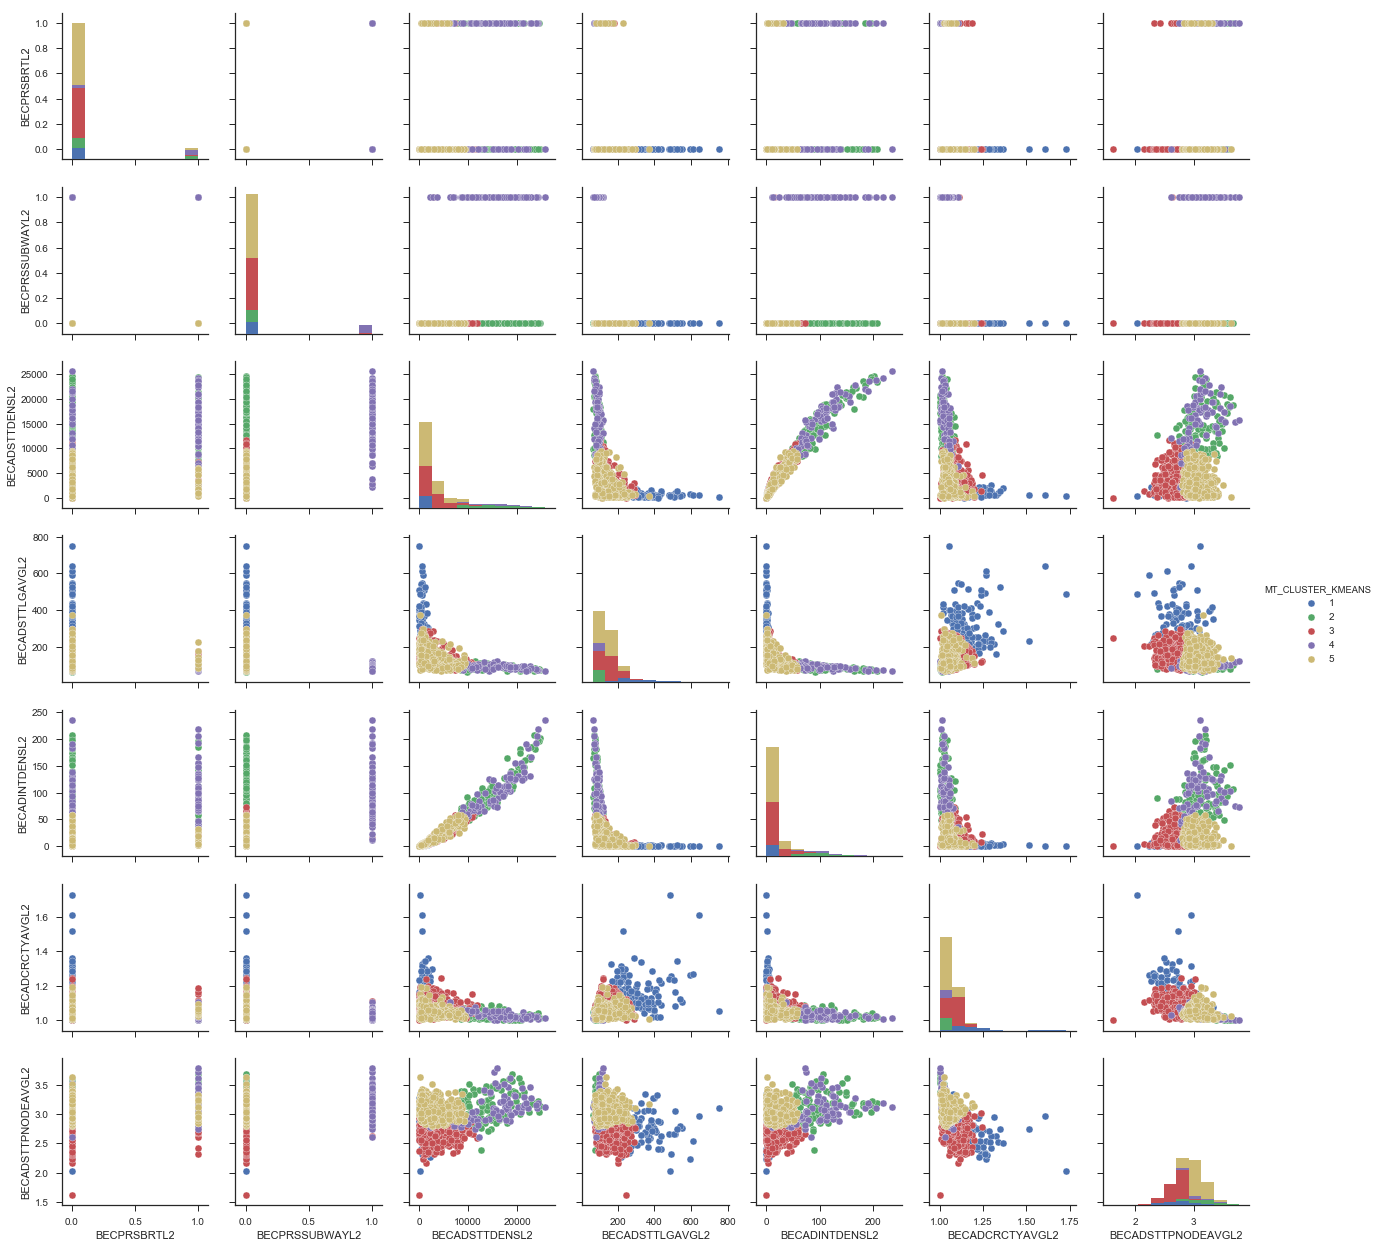

In [146]:
sns.pairplot( salurbal_df, vars = mt_features, hue = 'MT_CLUSTER_KMEANS' )

### Spectral Clustering

In [87]:
spectral_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'clustering', SpectralClustering( n_clusters = 5, n_jobs = -1, random_state = 1 ) )
] )

In [133]:
spectral_mbe_salurbal = spectral_pipeline.fit_predict( salurbal_df[ mbe_features ] )

for i in range( spectral_mbe_salurbal.shape[ 0 ] ):
    spectral_mbe_salurbal[ i ] = spectral_mbe_salurbal[ i ] + 1

In [134]:
spectral_mt_salurbal = spectral_pipeline.fit_predict( salurbal_df[ mt_features ] )

for i in range( spectral_mt_salurbal.shape[ 0 ] ):
    spectral_mt_salurbal[ i ] = spectral_mt_salurbal[ i ] + 1

In [135]:
salurbal_df[ 'MBE_CLUSTER_SPECTRAL' ] = spectral_mbe_salurbal

salurbal_df[ 'MT_CLUSTER_SPECTRAL' ] = spectral_mt_salurbal

In [136]:
salurbal_df[ 'MBE_CLUSTER_SPECTRAL' ].value_counts( dropna = False )

3    458
1    261
2    228
4    220
5    184
Name: MBE_CLUSTER_SPECTRAL, dtype: int64

In [137]:
salurbal_df[ 'MT_CLUSTER_SPECTRAL' ].value_counts( dropna = False )

1    475
2    400
3    394
5     46
4     36
Name: MT_CLUSTER_SPECTRAL, dtype: int64

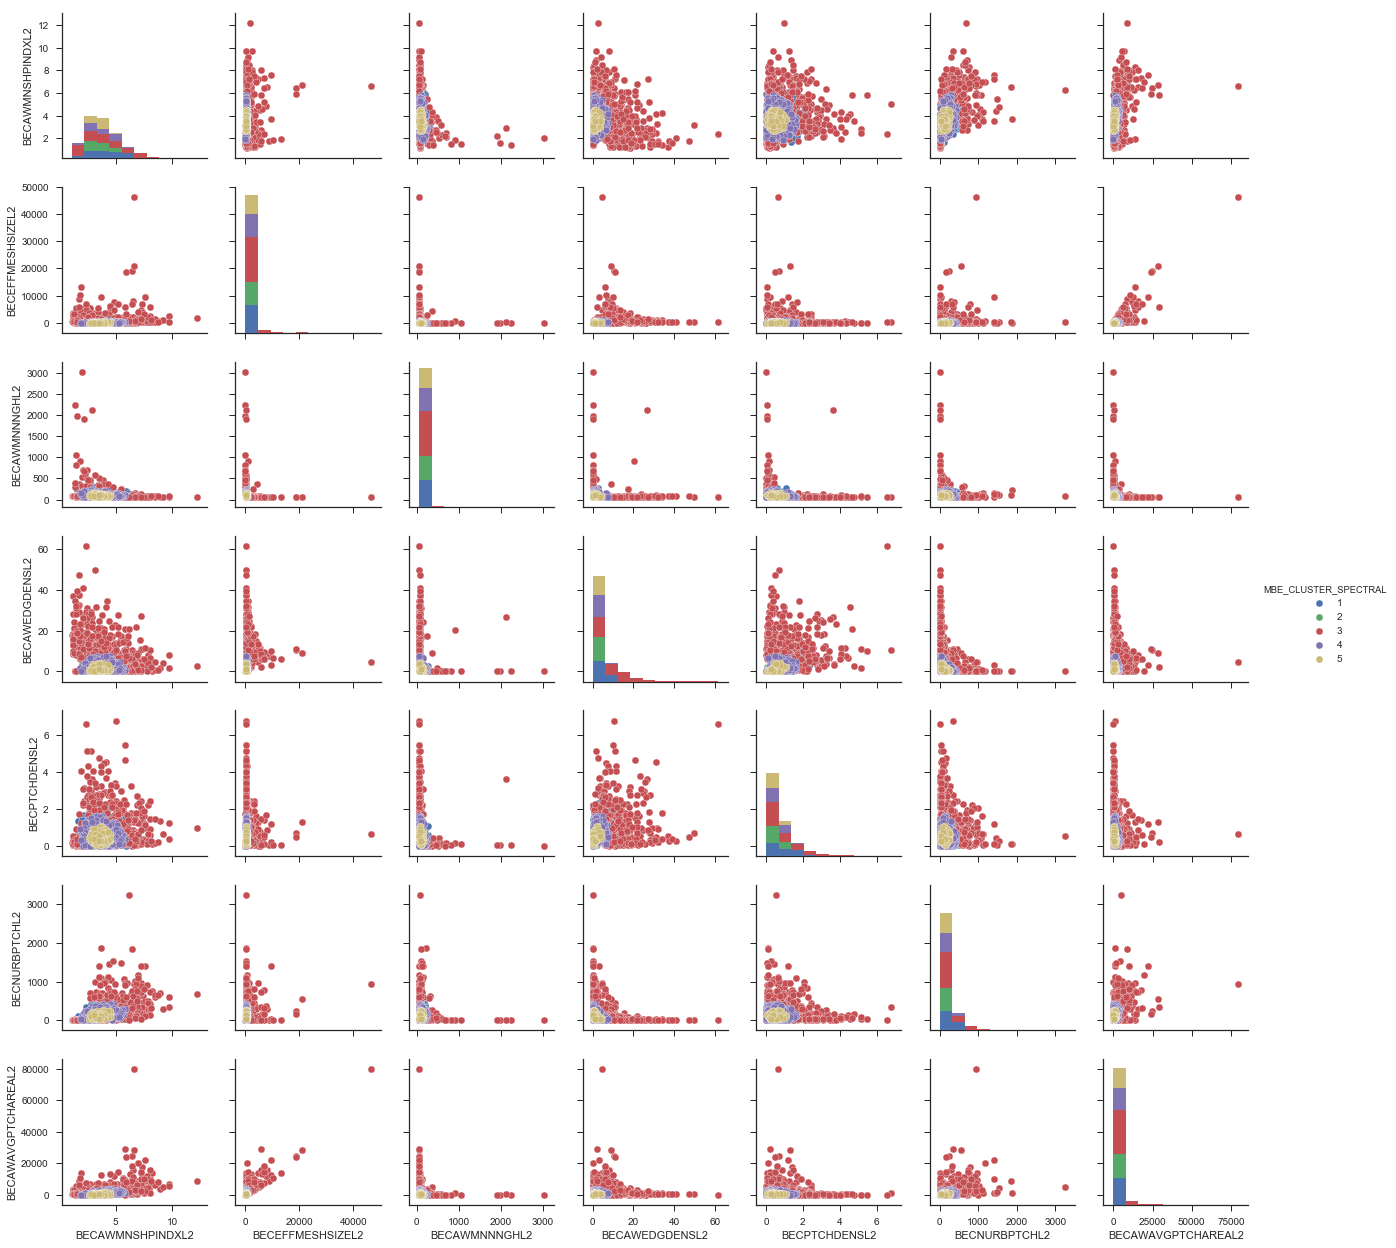

In [138]:
sns.pairplot( salurbal_df, vars = mbe_features, hue = 'MBE_CLUSTER_SPECTRAL' )

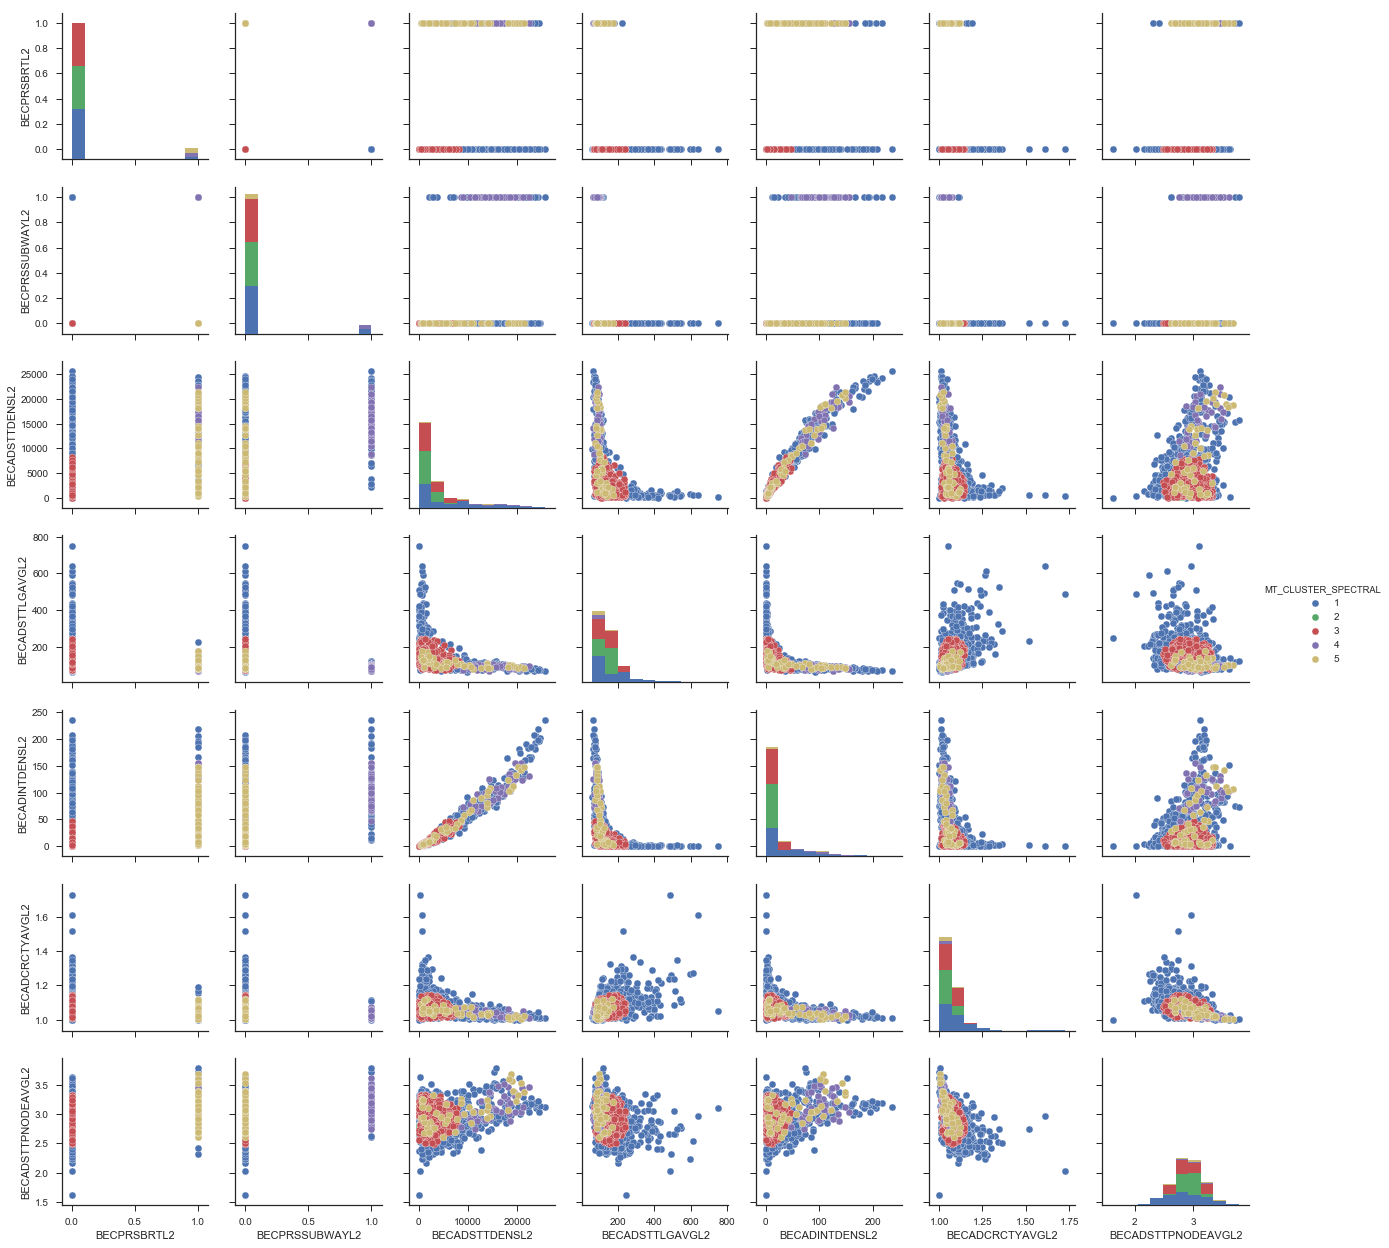

In [139]:
sns.pairplot( salurbal_df, vars = mt_features, hue = 'MT_CLUSTER_SPECTRAL' )

# Dimensionality Reduction

### T-SNE

In [97]:
tsne_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'dimred', TSNE( random_state = 1 ) )
] )

In [98]:
tsne_mbe_salurbal = tsne_pipeline.fit_transform( salurbal_df[ mbe_features ] )

In [99]:
tsne_mt_salurbal = tsne_pipeline.fit_transform( salurbal_df[ mt_features ] )

In [100]:
salurbal_df[ 'TSNE_MBE_X' ] = tsne_mbe_salurbal[ :, 0 ]
salurbal_df[ 'TSNE_MBE_Y' ] = tsne_mbe_salurbal[ :, 1 ]

salurbal_df[ 'TSNE_MT_X' ] = tsne_mt_salurbal[ :, 0 ]
salurbal_df[ 'TSNE_MT_Y' ] = tsne_mt_salurbal[ :, 1 ]

### PCA

In [101]:
pca_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'dimred', PCA( n_components = 2, random_state = 1 ) )
] )

In [102]:
pca_mbe_salurbal = pca_pipeline.fit_transform( salurbal_df[ mbe_features ] )
pca_pipeline.named_steps[ 'dimred' ].explained_variance_ratio_

array([0.31359875, 0.22862387])

In [103]:
pca_mt_salurbal = pca_pipeline.fit_transform( salurbal_df[ mt_features ] )
pca_pipeline.named_steps[ 'dimred' ].explained_variance_ratio_

array([0.47321718, 0.18717018])

In [104]:
salurbal_df[ 'PCA_MBE_X' ] = pca_mbe_salurbal[ :, 0 ]
salurbal_df[ 'PCA_MBE_Y' ] = pca_mbe_salurbal[ :, 1 ]

salurbal_df[ 'PCA_MT_X' ] = pca_mt_salurbal[ :, 0 ]
salurbal_df[ 'PCA_MT_Y' ] = pca_mt_salurbal[ :, 1 ]

### UMAP

In [105]:
umap_pipeline = Pipeline( [
    ( 'scaling', StandardScaler() ),
    ( 'dimred', umap.UMAP() )
] )

In [106]:
umap_mbe_salurbal = umap_pipeline.fit_transform( salurbal_df[ mbe_features ] )

C:\Users\fc.pena\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [107]:
umap_mt_salurbal = umap_pipeline.fit_transform( salurbal_df[ mt_features ] )

C:\Users\fc.pena\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\Users\fc.pena\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 3 connected components using meta-embedding (experimental)
  n_components


In [108]:
salurbal_df[ 'UMAP_MBE_X' ] = umap_mbe_salurbal[ :, 0 ]
salurbal_df[ 'UMAP_MBE_Y' ] = umap_mbe_salurbal[ :, 1 ]

salurbal_df[ 'UMAP_MT_X' ] = umap_mt_salurbal[ :, 0 ]
salurbal_df[ 'UMAP_MT_Y' ] = umap_mt_salurbal[ :, 1 ]

# Visualization

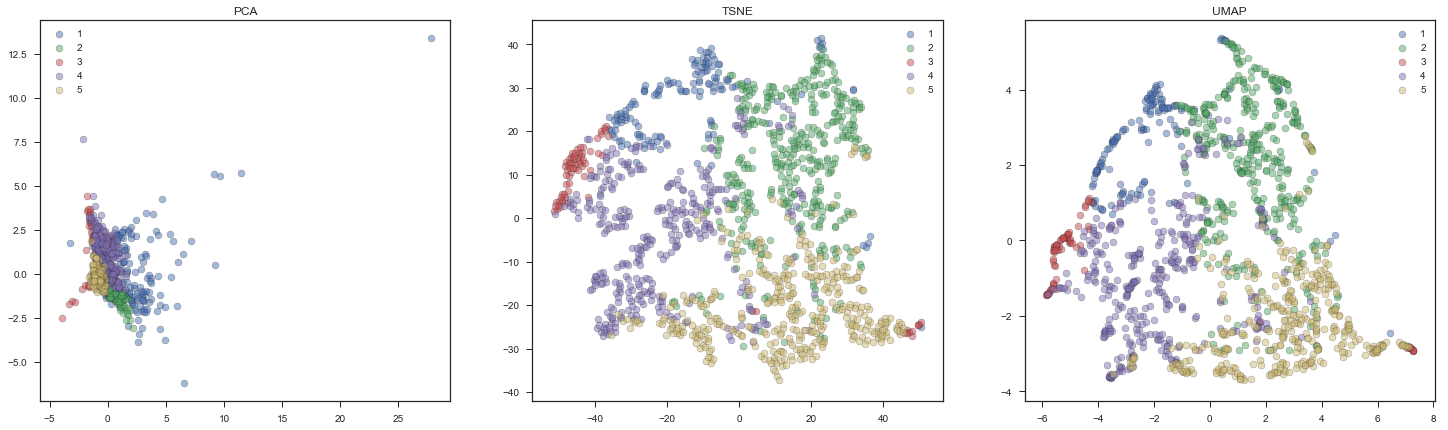

In [118]:
f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MBE'
clustering = ''
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

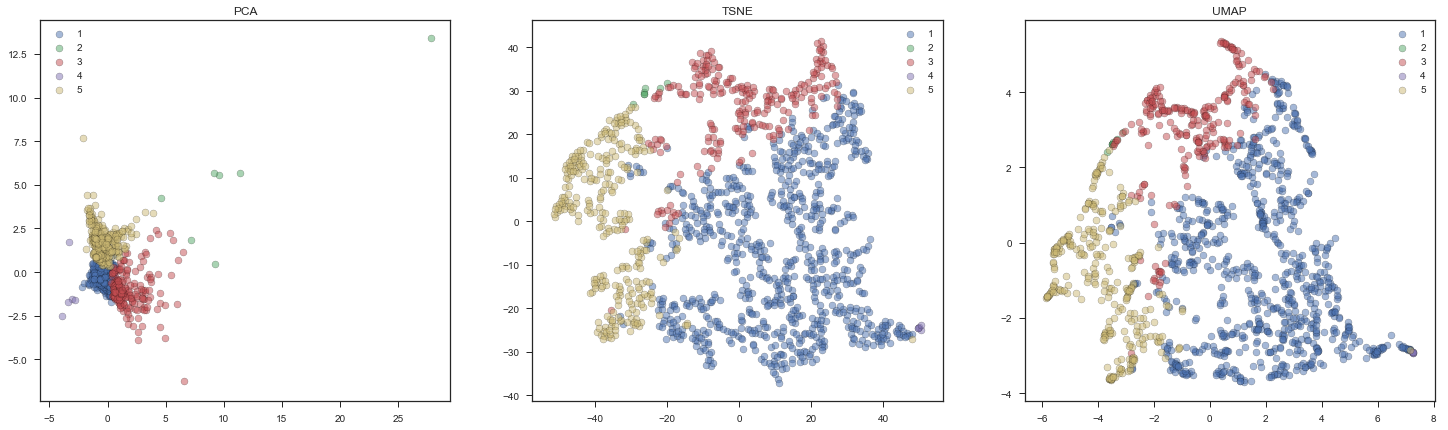

In [147]:
f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MBE'
clustering = '_KMEANS'
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

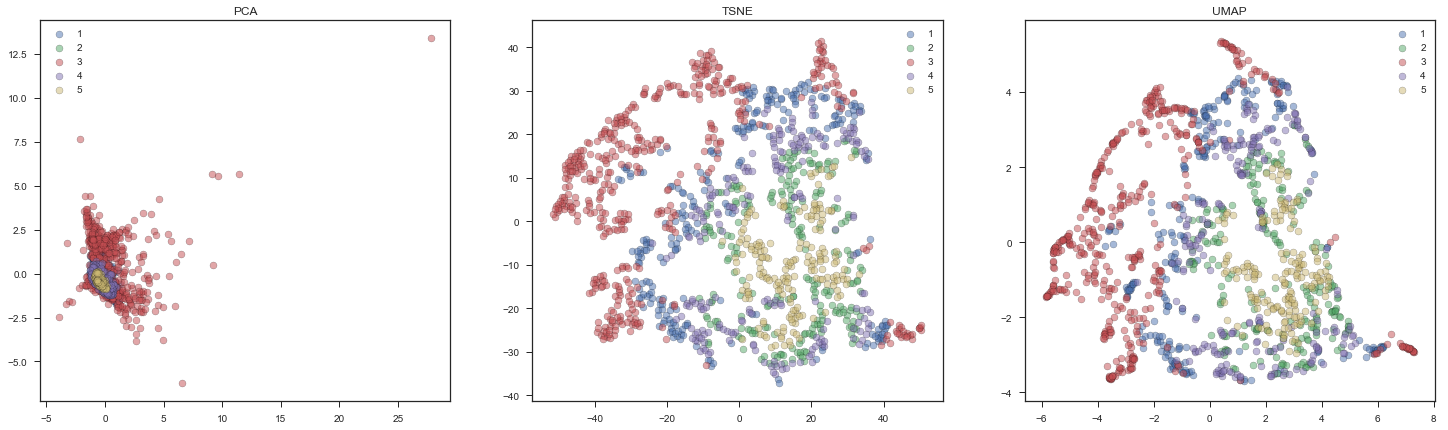

In [148]:
f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MBE'
clustering = '_SPECTRAL'
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

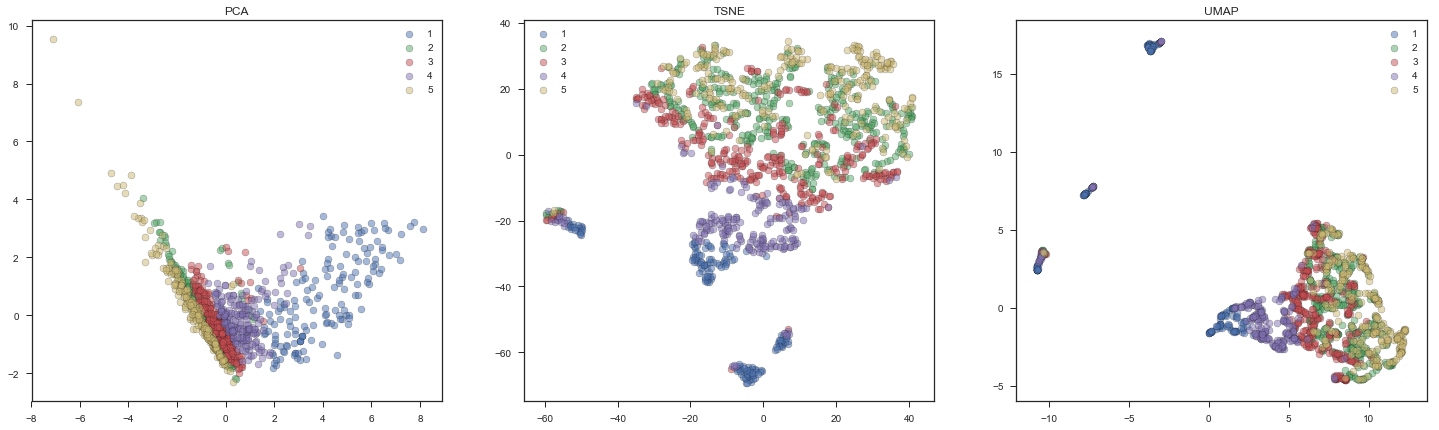

In [149]:
f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MT'
clustering = ''
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

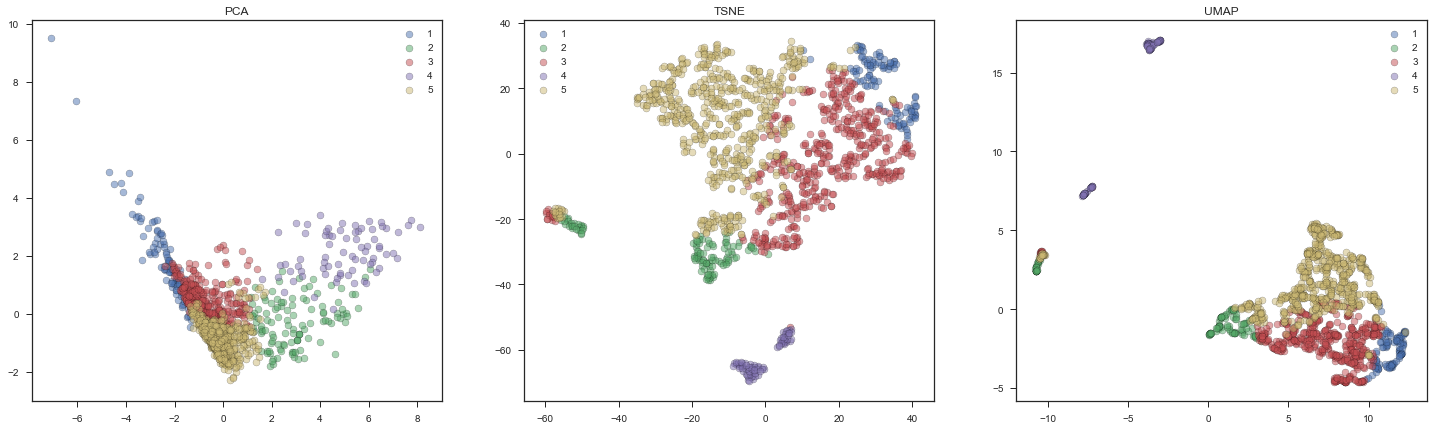

In [150]:
f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MT'
clustering = '_KMEANS'
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

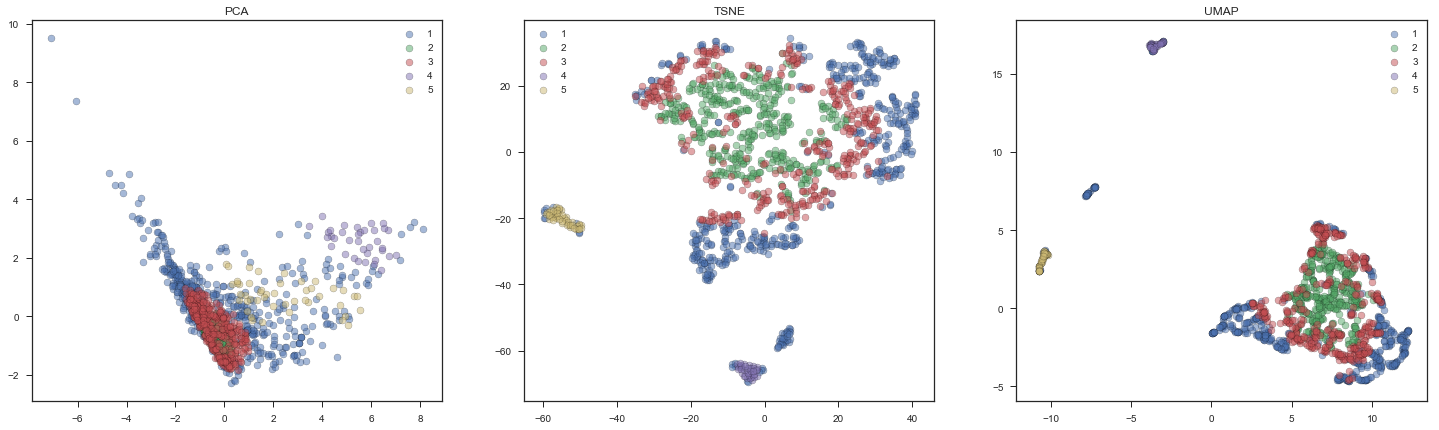

In [151]:
f, ( ax1, ax2, ax3 ) = plt.subplots( 1, 3,  figsize = ( 25, 7 ) )

model = 'MT'
clustering = '_SPECTRAL'
methods = { 'PCA' : ax1, 'TSNE' : ax2, 'UMAP' : ax3 }
for method in methods:
    for c in range( 1, 6 ):
        methods[ method ].scatter( salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_X' ], salurbal_df.loc[ salurbal_df[ model + '_CLUSTER' + clustering ] == c ][ method + '_' + model + '_Y' ], label = str( c ), edgecolor = 'black', alpha = 0.5 )
    methods[ method ].set_title( method )
    methods[ method ].legend()
plt.show()

In [152]:
salurbal_df.head()

MT_CLUSTER      MT_PROB1  MT_PROB2       MT_PROB3      MT_PROB4  MT_PROB5  \
0           2  1.006644e-09  0.990227   6.789038e-03  4.024870e-06   0.00298   
1           1  1.000000e+00  0.000000  2.597576e-165  2.851603e-16   0.00000   
2           1  1.000000e+00  0.000000  3.043838e-122  1.853233e-11   0.00000   
3           1  1.000000e+00  0.000000   4.062238e-92  3.665810e-08   0.00000   
4           1  1.000000e+00  0.000000  1.553341e-102  4.159393e-09   0.00000   

   MBE_CLUSTER     MBE_PROB1      MBE_PROB2     MBE_PROB3     MBE_PROB4  \
0            2  2.034067e-05   9.999797e-01  0.000000e+00  3.163931e-09   
1            3  8.495793e-09  1.196134e-305  9.999761e-01  2.393793e-05   
2            4  3.406003e-08   0.000000e+00  4.847438e-11  1.000000e+00   
3            3  1.018032e-05   0.000000e+00  5.970702e-01  4.029196e-01   
4            3  1.071469e-10  4.960718e-193  9.999799e-01  2.005005e-05   

       MBE_PROB5            L2NAME    COUNTRY  BECTUAREAL2  BECPCTURBANL2  \
0  2.548909e-228      Bahía Blanca  Argentina    6708.9607         2.9362   
1   0.000000e+00  CABA - Comuna 12  Argentina    1557.1800       100.0000   
2   0.000000e+00  CABA - Comuna 13  Argentina    1367.6403        92.9533   
3   0.000000e+00   CABA - Comuna 4  Argentina    2108.7000        95.1743   
4   0.000000e+00   CABA - Comuna 6  Argentina     684.9000       100.0000   

   BECNURBPTCHL2  BECPTCHDENSL2  BECAVGPTCHAREAL2  BECCVPTCHAREAL2  \
0            487         0.2131           13.7761        1381.9916   
1              1         0.0642         1557.1800           0.0000   
2             13         0.8836          105.2031         345.3484   
3              8         0.3611          263.5875         263.3112   
4              1         0.1460          684.9000           0.0000   

   BECAWMNSHPINDXL2  BECAWMNNNGHL2  BECEDGDENSL2  BECEFFMESHSIZEL2  \
0            5.1337       76.64910        3.0487           77.6599   
1            1.4735       76.50085        0.0000         1557.1800   
2            2.5395       60.04620       11.5814         1264.0834   
3            2.2122       67.16730        6.6347         1990.2022   
4            1.2914       76.50085        0.0000          684.9000   

   BECAWAVGPTCHAREAL2  BECAWEDGDENSL2  BECTPOPL2  BECPOPDENSL2  BECPOPCONCL2  \
0           2644.8742        0.420828   301664.6      2266.861      0.968855   
1           1557.1800       14.988633   198821.2     12768.030      0.466060   
2           1359.9129       24.739527   228600.5     16144.350      0.542869   
3           2091.1138       18.119355   208014.2      9748.383      0.588839   
4            684.9000       19.798511   172907.1     25245.600      0.394381   

   BECTPOPADJL2  BECPOPDENSADJL2  BECPRSBRTL2  BECPRSSUBWAYL2  \
0      303883.9         2283.536            0               0   
1      200283.8        12861.960            1               1   
2      230282.1        16263.110            1               1   
3      209544.2         9820.085            1               1   
4      174179.0        25431.300            0               1   

   BECBYLANELNGTHL2  BECADAREAL2  BECADCRCTYAVGL2  BECADINTDENS3L2  \
0               NaN  2288.640950         1.032761         1.814614   
1          9.701940    15.609046         1.010627        31.007661   
2          7.750455    14.761826         1.026108        32.516303   
3         10.812998    22.192225         1.027101        38.662188   
4          6.646486     6.867352         1.005764        30.142623   

   BECADINTDENS4L2  BECADINTDENSL2  BECADLRDENSL2  BECADSTTDENSL2  \
0         1.812866        3.672485       1.477944      939.287799   
1        68.934388      102.376535    1114.706121    18590.830836   
2        56.022881       90.571453     877.670053    16060.259206   
3        39.338101       79.577418     852.810300    14502.014548   
4        52.276336       83.147041    1318.272414    15379.258560   

   BECADSTTPNODEAVGL2  BECADSTTPNODESDL2  BECADSTTLGAVGL2 

In [153]:
salurbal_df.to_csv( '../data/modelos_l2.csv', index = False )

In [154]:
salurbal_df.to_csv( '../data/modelos_l2_comma.csv', sep = ';', index = False )

# Explanations

In [156]:
import lime
import lime.lime_tabular

In [165]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function
np.random.seed(1)

In [175]:
iris = sklearn.datasets.load_iris()

In [176]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(iris.data, iris.target, train_size=0.80)

C:\Users\fc.pena\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [177]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [178]:
sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

0.9333333333333333

In [179]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=iris.feature_names, class_names=iris.target_names, discretize_continuous=True)

In [180]:
i = np.random.randint(0, test.shape[0])
exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=2, top_labels=1)

In [181]:
exp.show_in_notebook(show_table=True, show_all=False)

In [159]:
salurbal_df[ mt_features ].dtypes

BECPRSBRTL2             int64
BECPRSSUBWAYL2          int64
BECADSTTDENSL2        float64
BECADSTTLGAVGL2       float64
BECADINTDENSL2        float64
BECADCRCTYAVGL2       float64
BECADSTTPNODEAVGL2    float64
dtype: object

In [163]:
','.join( mt_features )

'BECPRSBRTL2,BECPRSSUBWAYL2,BECADSTTDENSL2,BECADSTTLGAVGL2,BECADINTDENSL2,BECADCRCTYAVGL2,BECADSTTPNODEAVGL2'

In [164]:
explainer = lime.lime_tabular.LimeTabularExplainer( salurbal_df[ mt_features ], feature_names = ','.join( mt_features ), class_names = [ '1' , '2', '3', '4', '5' ], discretize_continuous = True )

TypeError: unhashable type: 'slice'